In [1]:
from keras import callbacks
from keras.optimizers import Adam
from keras.models import load_model
import numpy as np

Using TensorFlow backend.


In [4]:
# My functions are defined in a file lib.py, make sure it automaticall refreshes as well

%load_ext autoreload
%autoreload 2  
import lib

In [5]:
# Set parameters

# Data types:
# wi: warped images
# wc: warped segmentations
# mwc: modulated warped segmentations
DataType      = 'mwc'
UseDownSamp   = False
UseSmooth     = False
TrainModel    = True
EarlyStopping = False
Do2D          = True

PthTrainScr = '../Scores/training_fluid_intelligenceV1.csv'
PthValScr   = '../Scores/validation_fluid_intelligenceV1.csv'
DirABCD     = '/home/mbrud/Data/challenges/ABCD-default/fmriresults01/image03/'
if UseDownSamp and UseSmooth:
    DirData = '../Data/' + DataType + '--samp0.5-fwhm12'
elif UseDownSamp:
    DirData = '../Data/' + DataType + '--samp0.5'    
elif UseSmooth:
    DirData = '../Data/' + DataType + '--fwhm12'        
else:
    DirData = '../Data/' + DataType + ''
PthModel    = '../Results/model-' + DataType + '.h5'
DirLog      = '../Log/'

print('DirData = ' + DirData)

DirData = ../Data/mwc


In [6]:
# Get ABCD targets (IQ scores)

ScoresTrain = lib.get_abcd_scores(PthTrainScr)
ScoresVal   = lib.get_abcd_scores(PthValScr)

print('len(ScoresTrain) = ' + str(len(ScoresTrain)))
print('len(ScoresVal)   = ' + str(len(ScoresVal)))

len(ScoresTrain) = 3739
len(ScoresVal)   = 415


Input dimensions       = (102, 132, 3)
TotalSamples           = 7802, mu(y) = -8.210411968340108e-17, var(y) = 84.44684817509786
TotalTrainingSamples   = 3739, mu(y) = 0.05579177463128638, var(y) = 85.84989009890943
TotalValidationSamples = 415, mu(y) = -0.5026637237262179, var(y) = 71.52523224480278
TotalTestSamples       = 3648


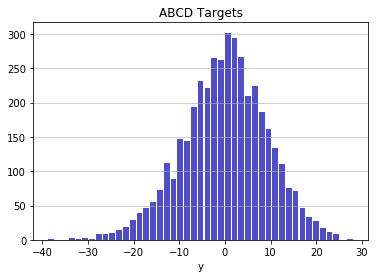

In [7]:
# Get training data (X,y)

X_train, X_valid, X_test, y_train, y_valid, Shape  = lib.X_split_abcd(DirData,ScoresTrain,ScoresVal,Do2D)

y = np.concatenate((y_train,y_valid))

# Some output
print('Input dimensions       = ' + str(Shape))

TotalTrainingSamples   = len(X_train)
TotalValidationSamples = len(X_valid)
TotalTestSamples       = len(X_test)
TotalSamples           = TotalTrainingSamples + TotalValidationSamples + TotalTestSamples

print('TotalSamples           = ' + str(TotalSamples) + ', mu(y) = ' + str(np.mean(y))  + ', var(y) = ' + str(np.var(y)))
print('TotalTrainingSamples   = ' + str(TotalTrainingSamples) + ', mu(y) = ' + str(np.mean(y_train))  + ', var(y) = ' + str(np.var(y_train)))
print('TotalValidationSamples = ' + str(TotalValidationSamples) + ', mu(y) = ' + str(np.mean(y_valid))  + ', var(y) = ' + str(np.var(y_valid)))
print('TotalTestSamples       = ' + str(TotalTestSamples))

lib.plot_histogram(y)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


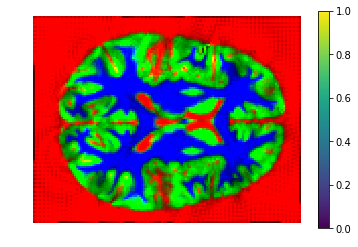

In [8]:
# Look at a training sample

ix = 0
lib.imshow(X_train[ix],Shape)

In [9]:
# Look at filenames and scores. To make sure that training data is OK, by comparing
# with what is in the .csv file (PthScores)

N = 2

print('------------------')
print('Training set')
X_temp = X_train
y_temp = y_train
for i in range(0,N):
    print(lib.get_filename(X_temp[i]))
    print(y_temp[i])
    print()
    
print('------------------')    
print('Validation set')
X_temp = X_valid
y_temp = y_valid
for i in range(0,N):
    print(lib.get_filename(X_temp[i]))
    print(y_temp[i])
    print()
    
print('------------------')    
print('Test set')
X_temp = X_test
for i in range(0,N):
    print(lib.get_filename(X_temp[i]))
    print()    

------------------
Training set

../Data/mwc/NDAR_INV007W6H7B/mwc1cr_NDAR_INV007W6H7B_t1_brain.nii
../Data/mwc/NDAR_INV007W6H7B/mwc2cr_NDAR_INV007W6H7B_t1_brain.nii
../Data/mwc/NDAR_INV007W6H7B/mwc3cr_NDAR_INV007W6H7B_t1_brain.nii
3.47196873636301


../Data/mwc/NDAR_INV00CY2MDM/mwc1cr_NDAR_INV00CY2MDM_t1_brain.nii
../Data/mwc/NDAR_INV00CY2MDM/mwc2cr_NDAR_INV00CY2MDM_t1_brain.nii
../Data/mwc/NDAR_INV00CY2MDM/mwc3cr_NDAR_INV00CY2MDM_t1_brain.nii
-8.95880581503893

------------------
Validation set

../Data/mwc/NDAR_INV01NAYMZH/mwc1cr_NDAR_INV01NAYMZH_t1_brain.nii
../Data/mwc/NDAR_INV01NAYMZH/mwc2cr_NDAR_INV01NAYMZH_t1_brain.nii
../Data/mwc/NDAR_INV01NAYMZH/mwc3cr_NDAR_INV01NAYMZH_t1_brain.nii
-9.3623908273812


../Data/mwc/NDAR_INV042UJKFB/mwc1cr_NDAR_INV042UJKFB_t1_brain.nii
../Data/mwc/NDAR_INV042UJKFB/mwc2cr_NDAR_INV042UJKFB_t1_brain.nii
../Data/mwc/NDAR_INV042UJKFB/mwc3cr_NDAR_INV042UJKFB_t1_brain.nii
-6.56811632771934

------------------
Test set

../Data/mwc/NDAR_INV005V6D2C/mwc1cr

In [10]:
# Define CNN regression model

model = lib.get_model_new(Shape,
                          Do2D,
                          filters   = ([64,1],[128,1],[256,1],[512,1]),
                          dense     = ([1024,0]),
                          batchNorm = False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 102, 132, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 102, 132, 64)      1792      
_________________________________________________________________
activation_1 (Activation)    (None, 102, 132, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 51, 66, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 51, 66, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 51, 66, 128)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 33, 128)       0         
__________

In [11]:
NbEpochs      = 50
BatchSize     = 16
LearningRate  = 1e-4

# Compile CNN model
#model.compile(loss='mean_absolute_error', optimizer=Adam(lr=LearningRate), metrics=['mse'])
model.compile(loss='mean_squared_error', optimizer=Adam(lr=LearningRate), metrics=['mse'])

# Define generators
training_generator   = lib.data_generator(X_train,y_train,Shape,BatchSize,Do2D)
validation_generator = lib.data_generator(X_valid,y_valid,Shape,BatchSize,Do2D)
#test_generator       = lib.data_generator(X_test,[],Shape,BatchSize)

if TrainModel:
    # Train a new model
    
    # Define callback for TensorBoard
    tbCallBack = callbacks.TensorBoard(log_dir=DirLog, 
                                       histogram_freq=0, 
                                       write_graph=True, 
                                       write_images=True)    
    
    # Define callback to ensure we save the best performing model
    checkpointer = callbacks.ModelCheckpoint(filepath=PthModel, 
                                             verbose=1, 
                                             save_best_only=True)    

    # Define callback for early stopping
    earlystop = callbacks.EarlyStopping(monitor='val_loss', 
                                        min_delta=0, 
                                        patience=0, 
                                        verbose=0, mode='auto', baseline=None, restore_best_weights=False)

    #cb = [earlystop]
    cb = None
    
    # Fit model
    # For training loss, keras does a running average over the batches. 
    # For validation loss, a conventional average over all the batches in validation data is performed. 
    model.fit_generator(training_generator,
                        nb_epoch=NbEpochs,
                        validation_data=validation_generator,
                        steps_per_epoch=TotalTrainingSamples/BatchSize,
                        validation_steps=TotalValidationSamples/BatchSize,
                        callbacks=cb,
                        verbose=2) # 0 = silent, 1 = progress bar, 2 = one line per epoch

    # Load best model
    del model 
    model = load_model(PthModel)
else:
    # Load an already trained model
        
    model.load_weights(PthModel)        

/home/mbrud/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/mbrud/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., steps_per_epoch=233.6875, validation_steps=25.9375, callbacks=None, verbose=2, epochs=50)`


Epoch 1/50
 - 10s - loss: 5.3879 - mean_squared_error: 5.3879 - val_loss: 5.4797 - val_mean_squared_error: 5.4797
Epoch 2/50
 - 6s - loss: 4.4917 - mean_squared_error: 4.4917 - val_loss: 3.5611 - val_mean_squared_error: 3.5611
Epoch 3/50
 - 6s - loss: 4.1526 - mean_squared_error: 4.1526 - val_loss: 6.1958 - val_mean_squared_error: 6.1958
Epoch 4/50
 - 6s - loss: 5.3881 - mean_squared_error: 5.3881 - val_loss: 4.2209 - val_mean_squared_error: 4.2209
Epoch 5/50
 - 6s - loss: 5.4063 - mean_squared_error: 5.4063 - val_loss: 4.0936 - val_mean_squared_error: 4.0936
Epoch 6/50
 - 6s - loss: 4.9670 - mean_squared_error: 4.9670 - val_loss: 4.9755 - val_mean_squared_error: 4.9755
Epoch 7/50
 - 6s - loss: 5.1358 - mean_squared_error: 5.1358 - val_loss: 3.6089 - val_mean_squared_error: 3.6089
Epoch 8/50
 - 6s - loss: 4.6583 - mean_squared_error: 4.6583 - val_loss: 2.8946 - val_mean_squared_error: 2.8946
Epoch 9/50
 - 6s - loss: 5.1591 - mean_squared_error: 5.1591 - val_loss: 8.0988 - val_mean_squa

In [12]:
# Evaluate model on validation set

yp  = model.predict_generator(validation_generator,steps=TotalValidationSamples)
mse = np.mean(np.square(np.array(y_valid) - yp))
print('MSE = ' + str(mse))

MSE = 76.47067170734941


In [ ]:
if False:
    # Evaluate model on test set

    yp  = model.predict_generator(test_generator,steps=TotalTestSamples)
    mse = np.mean(np.square(np.array(y_test) - yp))
    print('MSE = ' + str(mse))

In [ ]:
# A grid-search over different preprocessing options

%load_ext autoreload
%autoreload 2   
import lib

NbEpochs    = 50
BatchSize   = 16
PthTrainScr = '../Scores/training_fluid_intelligenceV1.csv'
PthValScr   = '../Scores/validation_fluid_intelligenceV1.csv'
DirData     = ['../Data/wi',
               '../Data/mwc',               
               '../Data/wc',]

for i in range(0,len(DirData)):
    print(DirData[i][8:])
    PthModel = '../Results/model_' + DirData[i][8:] + '.h5'    
    lib.run_predict(PthTrainScr,PthValScr,DirData[i],PthModel,NbEpochs,BatchSize)